In [1]:
import argparse
import os
import ruamel.yaml as yaml
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path
import pandas as pd 
import math 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from torch.utils.data import DataLoader

from models.model_retrieval import ALBEF
from models.vit import interpolate_pos_embed
from models.tokenization_bert import BertTokenizer

import utils
from dataset import create_dataset, create_sampler, create_loader
from scheduler import create_scheduler
from optim import create_optimizer
import matplotlib.pyplot as plt 
import cv2 

# ! 임시코드 
def from_false_to_unusable_bg(aug_json):
    temp = [] 
    for id,value in aug_json.items():
        try:
            temp.append([id,value['obj_bg']])
        except:
            temp.append([id,value['obj_bool']])
    df = pd.DataFrame(temp)        
    df.columns = ['id','obj_bg']
    
    false_ids = df[df['obj_bg']==False]['id'].values
    for id in false_ids:
        aug_json[id].pop('obj_bool')
        aug_json[id]['obj_bg'] = 'unusable_bg'
        
    save_json = [temp,aug_json]
    with open('./data/COCO/Annotations/train2014_rmg_0.01_bbox_center_0.7.json','w') as f:
        json.dump(save_json,f)

def make_df(aug_json):
    temp = [] 
    for id,value in aug_json.items():
        try:
            temp.append([id,value['obj_bg']])
        except:
            temp.append([id,value['obj_bool']])
    #df = pd.DataFrame(temp)        
    #df.columns = ['id','obj_bg']
    return temp


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RoMixGen:
    def __init__(self,json_file,image_root,transform_after_mix,normal_image_root,normal_image_transform,max_words= 50, resize_ratio=1):
        self.obj_bg_df = pd.DataFrame(json_file[0])
        self.aug_json = json_file[1]
        self.image_root = image_root 
        self.resize_ratio = resize_ratio 
        self.transform_after_mix = transform_after_mix
        
        self.normal_image_root = normal_image_root
        self.normal_transform = normal_image_transform 
        self.max_words = max_words 
        
    def bbox_point(self,bboxes):
        y_up = int(bboxes[1])
        y_down = y_up + int(bboxes[3])
        x_left = int(bboxes[0])
        x_right = x_left + int(bboxes[2])
        return x_left,x_right,y_up,y_down
    
    def __cut_obj__(self,bboxes,obj_img):
        x_left,x_right,y_up,y_down = self.bbox_point(bboxes)
        obj_img = np.array(obj_img)[y_up:y_down,x_left:x_right,:]
        return obj_img 
    
    def __obj_img__(self,obj_img):
        #! obj img 
        # obj 이미지 cutting 
        bboxes = self.obj_inform['max_obj_bbox']
        obj_img = self.__cut_obj__(bboxes,obj_img)
        
        #배경 이미지의 bbox 포인트 값 및 width, height 계산 
        bg_bboxes = self.bg_inform['max_obj_bbox']
        bg_x_left,bg_x_right,bg_y_up,bg_y_down = self.bbox_point(bg_bboxes)

        width = bg_x_right - bg_x_left
        height = bg_y_down - bg_y_up 

        #resize 기준 및 length 계산 
        #length = {'w_h':'height','length':height} if height > width else {'w_h':'width','length':width}
        length = {'w_h':'height','length':height} if obj_img.shape[0] < obj_img.shape[1] else {'w_h':'width','length':width}
        
        #resize 기준 대비 다른 길이 비율 계산 
        obj_ratio = obj_img.shape[0] / obj_img.shape[1] #height / width 
        #resize 
        if length['w_h'] == 'height': # height 
            dsize = (int(length['length']/obj_ratio*self.resize_ratio),int(length['length']*self.resize_ratio))
            obj_img = cv2.resize(obj_img,dsize=(dsize))
        else:                         # width 
            dsize = (int(length['length']*self.resize_ratio),int(length['length']*obj_ratio*self.resize_ratio))
            obj_img = cv2.resize(obj_img,dsize=(dsize))
        return obj_img 
        
    def __bg_img__(self,obj_img,bg_img):
        bg_img = np.array(bg_img)
        
        # boj 이미지의 width, height 계산 
        height = obj_img.shape[0]
        width = obj_img.shape[1]
        
        # 배경 이미지의 mid point랑 obj 이미지의 shape으로 붙일 영역 계산
        mid_x = int(self.bg_inform['max_obj_midpoint'][0])
        mid_y = int(self.bg_inform['max_obj_midpoint'][1])

        x_left = mid_x - math.ceil(width/2)
        x_right = mid_x + int(width/2)

        y_up = mid_y - math.ceil(height/2)
        y_down = mid_y + int(height/2)
        
                
        # 배경 벗어나는 것 보정 
        if y_up <0:
            y_down = y_down - y_up
            y_up = y_up - y_up

        if y_down > bg_img.shape[0]:
            move_length = y_down - bg_img.shape[0]
            y_up,y_down = y_up - move_length, y_down - move_length  
            
        if x_left < 0:
            x_left,x_right = x_right-x_left,x_left-x_left
            
        if x_right > bg_img.shape[1]:
            move_length = x_right - bg_img.shape[1]
            x_left,x_right = x_left-move_length,x_right-move_length

        # 배경에 obj 이미지 paste 
        bg_img[y_up:y_down,x_left:x_right,:] = 0 
        bg_img[y_up:y_down,x_left:x_right,:] = obj_img
        
        return bg_img 
        
    def __img_mix__(self,obj_id,bg_id):
        self.obj_inform = self.aug_json[obj_id]
        self.bg_inform = self.aug_json[bg_id]
        
        # image open 
        obj_img = Image.open(os.path.join(self.image_root,'obj',self.obj_inform['file_name'])).convert('RGB')
        bg_img  = Image.open(os.path.join(self.image_root,'bg',self.bg_inform['file_name'])).convert('RGB')
        
        obj_img = self.__obj_img__(obj_img)
        bg_img = self.__bg_img__(obj_img,bg_img)
        
        img = self.transform_after_mix(Image.fromarray(bg_img))
        return img 
        
    def normal_load(self,ann):
        image_path = os.path.join(self.normal_image_root,ann['image'])
        image = Image.open(image_path).convert('RGB')
        image = self.normal_transform(image)
        caption = pre_caption(ann['caption'],self.max_words)
        return image,caption 
        
    def mix(self,obj_id,bg_id):
        
        img = self.__img_mix__(obj_id,bg_id)
        #txt = self.__txt_mix__(obj_id,bg_id)
        return img,'_'
        
        
    def __call__(self,ann):
        image_id = ann['image_id'].split('_')[-1]
        try:
            if self.aug_json[image_id]['obj_bg'] =='obj':
                obj_id = image_id 
                bg_id = np.random.choice(self.obj_bg_df[self.obj_bg_df[1]=='bg'][0].values)
                img,caption = self.mix(obj_id,bg_id)
                
            elif self.aug_json[image_id]['obj_bg'] == 'bg':
                bg_id = image_id 
                obj_id = np.random.choice(self.obj_bg_df[self.obj_bg_df[1]=='obj'][0].values)
                img,caption = self.mix(obj_id,bg_id)            
            else:
                img,caption = self.normal_load(ann)
        except:
            img,caption = self.normal_load(ann)    
        return img,caption
            

In [3]:
from torch.utils.data import Dataset
from dataset.utils import pre_caption

class re_train_dataset(Dataset):
    def __init__(self, ann_file,romixgen,transform, image_root,mixgen=True,mixgen_ratio=0.1, max_words=30):        
        self.ann = []
        for f in ann_file:
            self.ann += json.load(open(f,'r'))
        self.transform = transform
        self.image_root = image_root
        self.max_words = max_words
        
        self.romixgen = romixgen 
        self.mixgen = mixgen 
        self.mixgen_ratio = mixgen_ratio
        
        self.img_ids = {}   
        
        n = 0
        for ann in self.ann:
            img_id = ann['image_id']
            if img_id not in self.img_ids.keys():
                self.img_ids[img_id] = n
                n += 1    
        
    def __len__(self):
        return len(self.ann)
    
    def __getitem__(self, index):    
        ann = self.ann[index]
        
        if (self.mixgen) & (random.random() < self.mixgen_ratio):
            image,caption = self.romixgen(ann)
        else:
            image_path = os.path.join(self.image_root,ann['image'])
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
        
            caption = pre_caption(ann['caption'],self.max_words)
        
        return image, caption, self.img_ids[ann['image_id']]
    


In [4]:
configs = yaml.load(open('./configs/Retrieval_coco.yaml'),Loader=yaml.Loader)
ann_file = json.load(open(configs['train_file'][0],'r'))

In [6]:
from torchvision import transforms 
from dataset.randaugment import RandomAugment
from PIL import Image 
train_transform = transforms.Compose([                        
            transforms.RandomResizedCrop(configs['image_res'],scale=(0.5, 1.0), interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(),
            RandomAugment(2,7,isPIL=True,augs=['Identity','AutoContrast','Equalize','Brightness','Sharpness',
                                              'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Rotate']),     
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])  
transform_after_mix = transforms.Compose([
    transforms.RandomResizedCrop(configs['image_res'],scale=(0.5, 1.0), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
romixgen = RoMixGen(json_file = json.load(open('./data/COCO/Annotations/train2014_rmg_0.01_bbox_center_0.7.json')),
                    image_root = './data/COCO/Images_0.01_bbox_center_0.7/',
                    transform_after_mix = transform_after_mix,
                    normal_image_root = './data/COCO/Images',
                    normal_image_transform = train_transform,
                    resize_ratio=3
                    )

In [7]:
trainset = re_train_dataset(ann_file = configs['train_file'],
                            romixgen = romixgen,
                            transform = train_transform,
                            image_root = configs['image_root'],
                            mixgen_ratio=1,
                            mixgen=True)

In [57]:
from torch.utils.data import DataLoader 
dataloader = DataLoader(trainset,batch_size=4,shuffle=True)

In [58]:
image,caption,id = next(iter(dataloader))

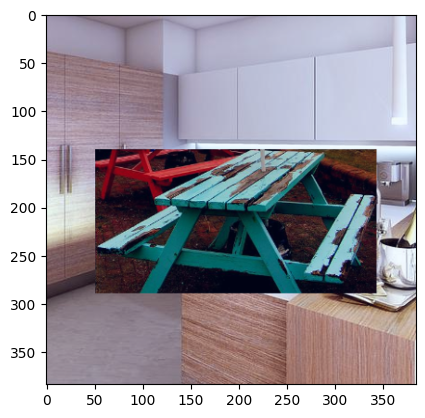

In [62]:
#ann = ann_file[800]
#ann = ann_file[1800]
#image,caption = romixgen(ann)
#image,caption,id = trainset.__getitem__(10000)
img = torch.permute(image[0],dims=(1,2,0)).detach().numpy()
plt.imshow((img-np.min(img)) / (np.max(img)-np.min(img)))
plt.show()